In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir ("/content/drive/MyDrive/FourthBrain/Capstone Samsung OCT/Data/OCT2017")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_dir = os.getcwd() + "/train/"
valid_dir = os.getcwd() + "/val/"
test_dir = os.getcwd() + "/test/"

In [30]:
classes = ['NORMAL', 'CNV', 'DME', 'DRUSEN']
cols = [x.lower() for x in classes]
dirs = [train_dir, valid_dir, test_dir]
label = {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}

REGEN = False # if we should read the directory structre, if False then use the CSV files already saved

In [5]:
def create_df (path, classes=classes):
  df = pd.DataFrame(columns=['filename', 'normal', 'cnv', 'dme', 'drusen'])
  for sub_dir in classes:
    condition = {'normal': 0, 'cnv': 0, 'dme':0, 'drusen': 0}
    files = os.listdir(path + sub_dir)
    if (sub_dir== 'NORMAL'):
      condition['normal'] = 1
    elif (sub_dir == 'CNV'):
      condition['cnv'] = 1
    elif (sub_dir == 'DME'):
      condition['dme'] = 1
    else:
      condition['drusen']= 1
    for f in files:
      df = df.append({'filename': path +  sub_dir  + "/" + f, 
                      'normal': condition['normal'], 
                      'cnv': condition['cnv'],
                      'dme': condition['dme'],
                      'drusen': condition['drusen']}, ignore_index=True)
  return df

In [6]:
# Generting the DataFrames of the filenames
# this is primarily used so we can sub-sample files easier for the different training strategies
if (REGEN):
  train_df = create_df(train_dir)
  valid_df = create_df(valid_dir)
  test_df = create_df(test_dir)
  train_df.to_csv("train_data.csv")
  valid_df.to_csv("valid_data.csv")
  test_df.to_csv("test_data.csv")
else:
  train_df = pd.read_csv("train_data.csv")
  valid_df = pd.read_csv("valid_data.csv")
  test_df = pd.read_csv("test_data.csv")

In [7]:
print ("Training Data: ", train_df.shape)
print ("Validation Data: ", valid_df.shape)
print ("Test Data: ", test_df.shape)

Training Data:  (83484, 6)
Validation Data:  (32, 6)
Test Data:  (968, 6)


In [8]:
# Printing out the # of samples for each subsample percentage 
print ("Trainig Data percentages:")
print (" 1% ==> ", int(.01 * train_df.shape[0]))
print (" 5% ==> ", int(.05 * train_df.shape[0]))
print ("10% ==> ", int(.1  * train_df.shape[0] ))
print ("25% ==> ", int(.25 * train_df.shape[0]))
print ("75% ==> ", int(.75 * train_df.shape[0]))
print ("90% ==> ", int(.9  * train_df.shape[0]))
print ("98% ==> ", int(.98 * train_df.shape[0]))

Trainig Data percentages:
 1% ==>  834
 5% ==>  4174
10% ==>  8348
25% ==>  20871
75% ==>  62613
90% ==>  75135
98% ==>  81814


In [9]:
# Sampling 1% of the data
sample = train_df.sample(frac=0.5, random_state=10, axis=0)
sample.shape

(41742, 6)

In [10]:
# determine class weights to feed into neural network during training
def get_classweight(df):
  total = df.shape[0]
  num_norm = df['normal'].sum()
  num_cnv = df['cnv'].sum()
  num_dme = df['dme'].sum()
  num_drusen = df['drusen'].sum()
  norm_weight = (1/num_norm) * (total/4)
  cnv_weight = (1/num_cnv) * (total/4)
  dme_weight = (1/num_dme) * (total/4)
  drusen_weight = (1/num_drusen) * (total/4)
  class_weight = {0 : cnv_weight, 1: dme_weight,
                  2 : drusen_weight, 3: norm_weight}
  return class_weight

In [11]:
class_weight = get_classweight(sample)
class_weight

{0: 0.5620152951314089,
 1: 1.8126628452318918,
 2: 2.413390379278446,
 3: 0.7970289467654471}

In [12]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.applications as app
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_image_datagen = ImageDataGenerator(rotation_range=90, width_shift_range=[-.1,.1], height_shift_range=[-.1,.1],
                                         shear_range=0.25, zoom_range=0.3, horizontal_flip=True,
                                         vertical_flip=True, rescale = 1./255., validation_split=.2)

# Setting the imgages to come from the dataframe where we specify the filenames and columns to use for "labels"
train_imgs = train_image_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=64, seed=10, subset='training')
valid_imgs = train_image_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, seed=10, subset='validation')

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


In [14]:
pre_process = keras.applications.densenet.preprocess_input
base_model = app.densenet.DenseNet121 (include_top=False, weights="imagenet", input_shape=(224,224,3), pooling=None)
base_model.trainable = False

# This is a must for Densenet as per documenatation, otherwise you get all kinds of errors when building model
input = keras.layers.Input(shape=(224,224,3))
x = pre_process(input)

# Creating DenseNet model
x = base_model(x)

#Layers added to Densenet
y = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(x)
y = keras.layers.BatchNormalization()(y)
x = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(y)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Concatenate()([x,y])
x = keras.layers.MaxPooling2D(2)(x)
y = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(x)
y = keras.layers.BatchNormalization()(y)
x = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(y)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Concatenate()([x,y])
#x = keras.layers.MaxPooling2D(2)(x)
#y = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(x)
#y = keras.layers.BatchNormalization()(y)
#x = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(y)
#x = keras.layers.BatchNormalization()(x)
#x = keras.layers.Concatenate()([x,y])
x = keras.layers.GlobalAveragePooling2D()(x)

# Output layer for the 4 classes we are dealing with
output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 224, 224, 3)  0           tf.math.truediv[0][0]            
__________________________________________________________________________________________________
tf.math.truediv_1 (TFOpLambda)  (None, 224, 224, 3)  0           tf.nn.bias_add[0][0]             
______________________________________________________________________________________________

In [15]:
# This code did not work, it caused I/O Error 5:
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics='accuracy')
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics='accuracy')

In [16]:
import datetime
%load_ext tensorboard
%reload_ext tensorboard

In [17]:
if not (os.path.exists('./logs/fit/')):
  os.mkdir('./logs/fit/')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Creating a checkpoint to save the best model so that we can reload it once training is complete
checkpoint_cb = keras.callbacks.ModelCheckpoint("oct_densenet.h5", save_best_only=True)
# Adding an an early stop callback to avoid overfitting in case the model is not improving after 5 consescutive epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# Tensorboard callback to view the training & validation curves
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
history = model.fit(train_imgs,  steps_per_epoch=40, epochs=100, verbose=1, validation_data=valid_imgs, 
                    class_weight=class_weight, callbacks=[checkpoint_cb]) #earlystop_cb]) # tensorboard_cb])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
40/40 [==============================] - 5325s 136s/step - loss: 1.4109 - accuracy: 0.3410 - val_loss: 11.5609 - val_accuracy: 0.1032
Epoch 2/100
40/40 [==============================] - 869s 22s/step - loss: 1.3813 - accuracy: 0.3918 - val_loss: 3.3597 - val_accuracy: 0.3161
Epoch 3/100
40/40 [==============================] - 846s 21s/step - loss: 1.3209 - accuracy: 0.4676 - val_loss: 3.5632 - val_accuracy: 0.1360
Epoch 4/100
40/40 [==============================] - 823s 21s/step - loss: 1.2808 - accuracy: 0.5211 - val_loss: 3.1503 - val_accuracy: 0.3158
Epoch 5/100
40/40 [==============================] - 791s 20s/step - loss: 1.2481 - accuracy: 0.5328 - val_loss: 2.9705 - val_accuracy: 0.3277
Epoch 6/100
40/40 [==============================] - 814s 21s/step - loss: 1.2837 - accuracy: 0.5105 - val_loss: 2.2367 - val_accuracy: 0.3377
E

In [19]:
sample_test = test_df.sample(frac=0.5, random_state=10, axis=0)
test_image_datagen = ImageDataGenerator( rescale = 1./255.)

test_imgs = test_image_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=16)

Found 968 images belonging to 4 classes.


In [20]:
model.load_weights("oct_densenet.h5")
model.evaluate(test_imgs)

61/61 [==============================] - 252s 4s/step - loss: 1.0855 - accuracy: 0.5145


[1.0854597091674805, 0.5144628286361694]

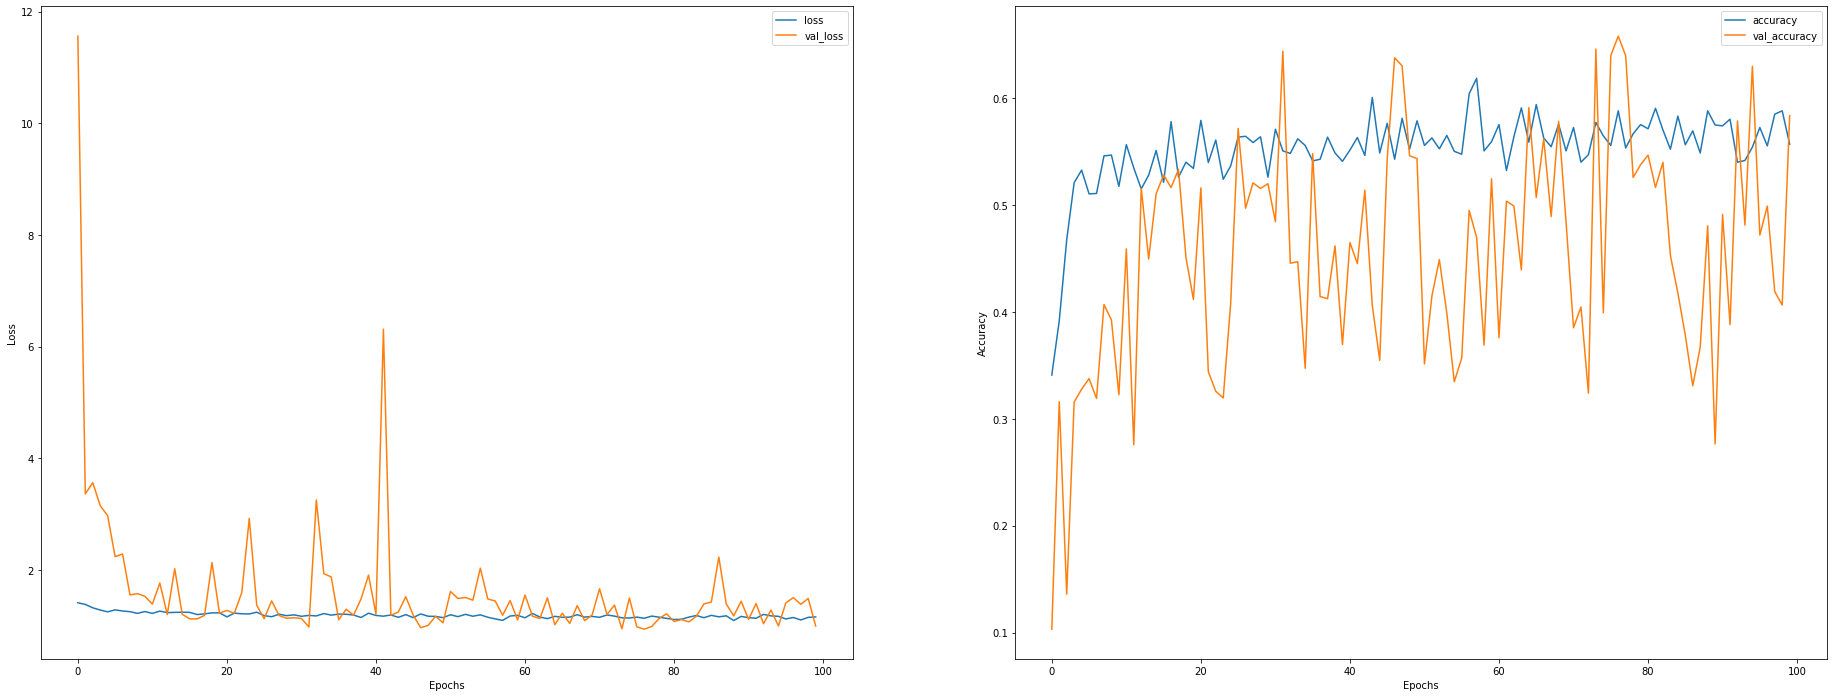

In [21]:
#Plotiting training results
plt.figure(figsize=(32,12))
plt.subplot(1,2,1)
plt.plot(range(len(history.history["loss"])), history.history['loss'], label="loss")
plt.plot(range(len(history.history["loss"])), history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(history.history["loss"])), history.history["accuracy"], label="accuracy")
plt.plot(range(len(history.history["loss"])), history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [22]:
results = model.predict(test_imgs)

In [23]:
results = np.argmax(results, axis=1)

In [31]:
from sklearn.metrics import classification_report

print (classification_report(test_imgs.labels, results, target_names=[label[i] for i in label]))

              precision    recall  f1-score   support

         CNV       0.27      0.50      0.35       242
         DME       0.27      0.09      0.13       242
      DRUSEN       0.00      0.00      0.00       242
      NORMAL       0.28      0.52      0.37       242

    accuracy                           0.28       968
   macro avg       0.21      0.28      0.21       968
weighted avg       0.21      0.28      0.21       968

